## Sentiment analysis implementation

### Key steps: 

- Textual preprocessing 
- TextBlob implementation
- BERT implementation 
- Evaluation

---

### Textual Preprocessing ###

Steps: 
- Efficiency: SpaCy is known for its speed and memory efficiency. It's designed to be fast and suitable for production environments where processing large amounts of text is required.

- Pre-trained Models: SpaCy provides pre-trained models for various languages that are capable of performing tasks like named entity recognition, part-of-speech tagging, and more. These models can be fine-tuned for specific applications.

- Tokenization: SpaCy efficiently splits text into individual words or tokens. This process is a fundamental step in NLP, as many subsequent tasks rely on having correctly segmented text.

- Part-of-Speech Tagging: The library can tag words in a sentence with their corresponding parts of speech, such as nouns, verbs, adjectives, etc.

- Named Entity Recognition (NER): SpaCy can identify and classify entities in text, such as names of people, organizations, locations, dates, and more.

- Dependency Parsing: Dependency parsing involves determining the grammatical relationships between words in a sentence. SpaCy can create dependency parse trees that represent these relationships.

- Lemmatization: SpaCy can transform words to their base or dictionary form (lemmas), which is useful for reducing words to their core meaning.

In [1]:
## Importing libraries 

# For data manipulation
import pandas as pd
import numpy as np

# For spaCy
import spacy

# For TextBlob
from textblob import TextBlob

# For train/test splits, metrics, etc.
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

# For BERT via Hugging Face
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
import torch.nn.functional as F

# For plotting  
import matplotlib.pyplot as plt
from spacy.lang.en.stop_words import STOP_WORDS




/Users/devishi/anaconda3/envs/fyp_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("cleaned_glassdoor_reviews.csv")  # Update with your correct filename
df.head()

,Company,Date Posted,Job Title,Location,Overall Rating,Work/Life Balance,Company Culture,Diversity Inclusion,Career Opportunity,Company Benefits,Management,Post Title,Pros,Cons,pros_length,cons_length
0,AFH-Wealth-Management,2015-04-05,,Unknown,2,4,3,NaN,2,3,3,"Young colleagues, poor micro management",Very friendly and welcoming to new staff. Easy...,"Poor salaries, poor training and communication.",10,6
1,AFH-Wealth-Management,2015-12-11,Office Administrator,"Bromsgrove, England, England",2,3,1,NaN,2,1,4,"Excellent staff, poor salary","Friendly, helpful and hard-working colleagues",Poor salary which doesn't improve much with pr...,5,19
2,AFH-Wealth-Management,2016-01-28,Office Administrator,"Bromsgrove, England, England",1,1,1,NaN,1,1,1,"Low salary, bad micromanagement",Easy to get the job even without experience in...,"Very low salary, poor working conditions, very...",10,33
3,AFH-Wealth-Management,2016-04-16,,Unknown,5,2,3,NaN,2,2,3,Over promised under delivered,Nice staff to work with,No career progression and salary is poor,5,7
4,AFH-Wealth-Management,2016-04-23,Office Administrator,"Bromsgrove, England, England",1,2,1,NaN,2,1,1,client reporting admin,"Easy to get the job, Nice colleagues.","Abysmal pay, around minimum wage. No actual tr...",7,41


Implementing SpaCy

In [3]:
import re

def clean_text(text):
    text = str(text)  # ensure it's a string
    text = text.encode("ascii", "ignore").decode()  # remove non-ASCII characters
    text = re.sub(r"\s+", " ", text)  # collapse multiple spaces/newlines/tabs
    text = re.sub(r"[^a-zA-Z0-9\s.,!?]", "", text)  # remove weird characters
    text = text.strip()  # trim leading/trailing whitespace
    return text

In [4]:
# Load the spaCy model
nlp = spacy.load("en_core_web_sm")

# Tokenize the text, and remove punctuation and stop words, lowercase and lemmatize the text, and return
# the remaining tokens as a list
def spacy_tokenizer(text, batch_size=500):
    result = []
    cleaned_texts = [clean_text(t) for t in text]  # Clean the texts first
    
    for doc in nlp.pipe(text, disable=["parser", "ner"], batch_size=batch_size):
        tokens = [
            token.lemma_.lower().strip() 
            for token in doc 
            if not token.is_stop and not token.is_punct and not token.like_num
        ]
        result.append(" ".join(tokens))
    return result

# Apply to both Pros and Cons columns
df["Pros_Clean"] = spacy_tokenizer(df["Pros"].astype(str).tolist(), batch_size=500)
df["Cons_Clean"] = spacy_tokenizer(df["Cons"].astype(str).tolist(), batch_size=500)




In [5]:
# save the cleaned data
df.to_csv("cleaned_glassdoor_reviews.csv", index=False)

df.head(10)



,Company,Date Posted,Job Title,Location,Overall Rating,Work/Life Balance,Company Culture,Diversity Inclusion,Career Opportunity,Company Benefits,Management,Post Title,Pros,Cons,pros_length,cons_length,Pros_Clean,Cons_Clean
0,AFH-Wealth-Management,2015-04-05,,Unknown,2,4,3,NaN,2,3,3,"Young colleagues, poor micro management",Very friendly and welcoming to new staff. Easy...,"Poor salaries, poor training and communication.",10,6,friendly welcome new staff easy go ethic,poor salary poor training communication
1,AFH-Wealth-Management,2015-12-11,Office Administrator,"Bromsgrove, England, England",2,3,1,NaN,2,1,4,"Excellent staff, poor salary","Friendly, helpful and hard-working colleagues",Poor salary which doesn't improve much with pr...,5,19,friendly helpful hard work colleague,poor salary improve progression incentive work...
2,AFH-Wealth-Management,2016-01-28,Office Administrator,"Bromsgrove, England, England",1,1,1,NaN,1,1,1,"Low salary, bad micromanagement",Easy to get the job even without experience in...,"Very low salary, poor working conditions, very...",10,33,easy job experience finance,low salary poor working condition little train...
3,AFH-Wealth-Management,2016-04-16,,Unknown,5,2,3,NaN,2,2,3,Over promised under delivered,Nice staff to work with,No career progression and salary is poor,5,7,nice staff work,career progression salary poor
4,AFH-Wealth-Management,2016-04-23,Office Administrator,"Bromsgrove, England, England",1,2,1,NaN,2,1,1,client reporting admin,"Easy to get the job, Nice colleagues.","Abysmal pay, around minimum wage. No actual tr...",7,41,easy job nice colleague,abysmal pay minimum wage actual training job r...
5,AFH-Wealth-Management,2016-05-26,Office Administrator,Unknown,3,4,2,NaN,2,3,2,Office administrator,Some good people to work with.\n\nFlexible wor...,Morale.\n\nLack of managerial structure.\n\nDo...,19,14,good people work flexible working hour langu...,morale lack managerial structure support car...
6,AFH-Wealth-Management,2016-09-23,IFA,"Bromsgrove, England, England",1,1,1,NaN,1,1,1,It horrible management,Good investment management strategy. Overall t...,The management and seniors are ruthless. No tr...,16,37,good investment management strategy overall in...,management senior ruthless training staff staf...
7,AFH-Wealth-Management,2016-09-25,Anonymous Employee,"Century City, CA",5,5,5,NaN,5,4,5,Good place to work,The people are great and the culture is very f...,Wouldn't necessarily say there are any cons to...,22,36,people great culture forward thinking lot deve...,necessarily con work website contain negative ...
8,AFH-Wealth-Management,2016-11-03,Anonymous Employee,Unknown,4,4,4,NaN,4,4,4,I liked working for AFH,"Nice Staff, good HR Team.\r\nFeels vibrant and...",Can't really think of any obvious cons,21,7,nice staff good hr team feel vibrant forward ...,think obvious con
9,AFH-Wealth-Management,2017-02-21,Technician,"Santa Ana, CA",1,1,1,NaN,1,3,1,Honest Review,Made some life time friends.,Was let go from the company just before Christ...,5,29,life time friend,let company christmas advise role cost effecti...


In [10]:
# implement the TextBlob sentiment analysis
def textblob_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Apply to both Pros and Cons columns
df["Pros_Sentiment"] = df["Pros_Clean"].apply(textblob_sentiment)
df["Cons_Sentiment"] = df["Cons_Clean"].apply(textblob_sentiment)


Do I add avaerage of pros and cons or do i pick the the most negative or most positive?

Apply 3 different methods of how to get overal sentiment of each review, taking into consideration of pros sentiment score and cons sentiment score

In [ ]:
# ---- Method 1: Average the sentiment scores of pros and cons to get overall sentiment ----

# Average the sentiment scores of pros and cons to get overall sentiment
df["Review_Sentiment"] = df[["Pros_Sentiment", "Cons_Sentiment"]].mean(axis=1)

df.head(10)

,Company,Date Posted,Job Title,Location,Overall Rating,Work/Life Balance,Company Culture,Diversity Inclusion,Career Opportunity,Company Benefits,...,Post Title,Pros,Cons,pros_length,cons_length,Pros_Clean,Cons_Clean,Pros_Sentiment,Cons_Sentiment,Review_Sentiment
0,AFH-Wealth-Management,2015-04-05,,Unknown,2,4,3,NaN,2,3,...,"Young colleagues, poor micro management",Very friendly and welcoming to new staff. Easy...,"Poor salaries, poor training and communication.",10,6,friendly welcome new staff easy go ethic,poor salary poor training communication,0.436174,-0.400000,0.018087
1,AFH-Wealth-Management,2015-12-11,Office Administrator,"Bromsgrove, England, England",2,3,1,NaN,2,1,...,"Excellent staff, poor salary","Friendly, helpful and hard-working colleagues",Poor salary which doesn't improve much with pr...,5,19,friendly helpful hard work colleague,poor salary improve progression incentive work...,0.041667,-0.232917,-0.095625
2,AFH-Wealth-Management,2016-01-28,Office Administrator,"Bromsgrove, England, England",1,1,1,NaN,1,1,...,"Low salary, bad micromanagement",Easy to get the job even without experience in...,"Very low salary, poor working conditions, very...",10,33,easy job experience finance,low salary poor working condition little train...,0.433333,0.010357,0.221845
3,AFH-Wealth-Management,2016-04-16,,Unknown,5,2,3,NaN,2,2,...,Over promised under delivered,Nice staff to work with,No career progression and salary is poor,5,7,nice staff work,career progression salary poor,0.600000,-0.400000,0.100000
4,AFH-Wealth-Management,2016-04-23,Office Administrator,"Bromsgrove, England, England",1,2,1,NaN,2,1,...,client reporting admin,"Easy to get the job, Nice colleagues.","Abysmal pay, around minimum wage. No actual tr...",7,41,easy job nice colleague,abysmal pay minimum wage actual training job r...,0.516667,-0.233333,0.141667
5,AFH-Wealth-Management,2016-05-26,Office Administrator,Unknown,3,4,2,NaN,2,3,...,Office administrator,Some good people to work with.\n\nFlexible wor...,Morale.\n\nLack of managerial structure.\n\nDo...,19,14,good people work flexible working hour langu...,morale lack managerial structure support car...,0.350000,0.000000,0.175000
6,AFH-Wealth-Management,2016-09-23,IFA,"Bromsgrove, England, England",1,1,1,NaN,1,1,...,It horrible management,Good investment management strategy. Overall t...,The management and seniors are ruthless. No tr...,16,37,good investment management strategy overall in...,management senior ruthless training staff staf...,0.325000,-0.533333,-0.104167
7,AFH-Wealth-Management,2016-09-25,Anonymous Employee,"Century City, CA",5,5,5,NaN,5,4,...,Good place to work,The people are great and the culture is very f...,Wouldn't necessarily say there are any cons to...,22,36,people great culture forward thinking lot deve...,necessarily con work website contain negative ...,0.800000,-0.150000,0.325000
8,AFH-Wealth-Management,2016-11-03,Anonymous Employee,Unknown,4,4,4,NaN,4,4,...,I liked working for AFH,"Nice Staff, good HR Team.\r\nFeels vibrant and...",Can't really think of any obvious cons,21,7,nice staff good hr team feel vibrant forward ...,think obvious con,0.541667,0.000000,0.270833
9,AFH-Wealth-Management,2017-02-21,Technician,"Santa Ana, CA",1,1,1,NaN,1,3,...,Honest Review,Made some life time friends.,Was let go from the company just before Christ...,5,29,life time friend,let company christmas advise role cost effecti...,0.000000,-0.050000,-0.025000


In [14]:
# ---- Method 2: Weightes Average ----

# Weighted average the sentiment scores of pros and cons to get overall sentiment
# using word length for each cleaned text

df["Pros_Length"] = df["Pros_Clean"].apply(lambda x: len(x.split()))
df["Cons_Length"] = df["Cons_Clean"].apply(lambda x: len(x.split()))
df["Total_Length"] = df["Pros_Length"] + df["Cons_Length"]

# Function to compute weighted sentiment, handling zero-length cases
def weighted_sentiment(row):
    if row["Total_Length"] == 0:
        return 0
    return ((row["Pros_Sentiment"] * row["Pros_Length"]) + 
            (row["Cons_Sentiment"] * row["Cons_Length"])) / row["Total_Length"]

df["Review_Sentiment_Weighted"] = df.apply(weighted_sentiment, axis=1)

df.head(10)

,Company,Date Posted,Job Title,Location,Overall Rating,Work/Life Balance,Company Culture,Diversity Inclusion,Career Opportunity,Company Benefits,...,cons_length,Pros_Clean,Cons_Clean,Pros_Sentiment,Cons_Sentiment,Review_Sentiment,Pros_Length,Cons_Length,Total_Length,Review_Sentiment_Weighted
0,AFH-Wealth-Management,2015-04-05,,Unknown,2,4,3,NaN,2,3,...,6,friendly welcome new staff easy go ethic,poor salary poor training communication,0.436174,-0.400000,0.018087,7,5,12,0.087768
1,AFH-Wealth-Management,2015-12-11,Office Administrator,"Bromsgrove, England, England",2,3,1,NaN,2,1,...,19,friendly helpful hard work colleague,poor salary improve progression incentive work...,0.041667,-0.232917,-0.095625,5,12,17,-0.152157
2,AFH-Wealth-Management,2016-01-28,Office Administrator,"Bromsgrove, England, England",1,1,1,NaN,1,1,...,33,easy job experience finance,low salary poor working condition little train...,0.433333,0.010357,0.221845,4,21,25,0.078033
3,AFH-Wealth-Management,2016-04-16,,Unknown,5,2,3,NaN,2,2,...,7,nice staff work,career progression salary poor,0.600000,-0.400000,0.100000,3,4,7,0.028571
4,AFH-Wealth-Management,2016-04-23,Office Administrator,"Bromsgrove, England, England",1,2,1,NaN,2,1,...,41,easy job nice colleague,abysmal pay minimum wage actual training job r...,0.516667,-0.233333,0.141667,4,23,27,-0.122222
5,AFH-Wealth-Management,2016-05-26,Office Administrator,Unknown,3,4,2,NaN,2,3,...,14,good people work flexible working hour langu...,morale lack managerial structure support car...,0.350000,0.000000,0.175000,12,9,21,0.200000
6,AFH-Wealth-Management,2016-09-23,IFA,"Bromsgrove, England, England",1,1,1,NaN,1,1,...,37,good investment management strategy overall in...,management senior ruthless training staff staf...,0.325000,-0.533333,-0.104167,10,17,27,-0.215432
7,AFH-Wealth-Management,2016-09-25,Anonymous Employee,"Century City, CA",5,5,5,NaN,5,4,...,36,people great culture forward thinking lot deve...,necessarily con work website contain negative ...,0.800000,-0.150000,0.325000,11,11,22,0.325000
8,AFH-Wealth-Management,2016-11-03,Anonymous Employee,Unknown,4,4,4,NaN,4,4,...,7,nice staff good hr team feel vibrant forward ...,think obvious con,0.541667,0.000000,0.270833,16,3,19,0.456140
9,AFH-Wealth-Management,2017-02-21,Technician,"Santa Ana, CA",1,1,1,NaN,1,3,...,29,life time friend,let company christmas advise role cost effecti...,0.000000,-0.050000,-0.025000,3,13,16,-0.040625


In [16]:
# ---- Method 3: Dominant Sentiment ----

# Function to compute dominant sentiment
# Choose the sentiment (Pros or Cons) with the higher absolute polarity
df["Review_Sentiment_Dominant"] = df.apply(
    lambda row: row["Pros_Sentiment"] if abs(row["Pros_Sentiment"]) > abs(row["Cons_Sentiment"]) else row["Cons_Sentiment"],
    axis=1)

df.head(10)



,Company,Date Posted,Job Title,Location,Overall Rating,Work/Life Balance,Company Culture,Diversity Inclusion,Career Opportunity,Company Benefits,...,Pros_Clean,Cons_Clean,Pros_Sentiment,Cons_Sentiment,Review_Sentiment,Pros_Length,Cons_Length,Total_Length,Review_Sentiment_Weighted,Review_Sentiment_Dominant
0,AFH-Wealth-Management,2015-04-05,,Unknown,2,4,3,NaN,2,3,...,friendly welcome new staff easy go ethic,poor salary poor training communication,0.436174,-0.400000,0.018087,7,5,12,0.087768,0.436174
1,AFH-Wealth-Management,2015-12-11,Office Administrator,"Bromsgrove, England, England",2,3,1,NaN,2,1,...,friendly helpful hard work colleague,poor salary improve progression incentive work...,0.041667,-0.232917,-0.095625,5,12,17,-0.152157,-0.232917
2,AFH-Wealth-Management,2016-01-28,Office Administrator,"Bromsgrove, England, England",1,1,1,NaN,1,1,...,easy job experience finance,low salary poor working condition little train...,0.433333,0.010357,0.221845,4,21,25,0.078033,0.433333
3,AFH-Wealth-Management,2016-04-16,,Unknown,5,2,3,NaN,2,2,...,nice staff work,career progression salary poor,0.600000,-0.400000,0.100000,3,4,7,0.028571,0.600000
4,AFH-Wealth-Management,2016-04-23,Office Administrator,"Bromsgrove, England, England",1,2,1,NaN,2,1,...,easy job nice colleague,abysmal pay minimum wage actual training job r...,0.516667,-0.233333,0.141667,4,23,27,-0.122222,0.516667
5,AFH-Wealth-Management,2016-05-26,Office Administrator,Unknown,3,4,2,NaN,2,3,...,good people work flexible working hour langu...,morale lack managerial structure support car...,0.350000,0.000000,0.175000,12,9,21,0.200000,0.350000
6,AFH-Wealth-Management,2016-09-23,IFA,"Bromsgrove, England, England",1,1,1,NaN,1,1,...,good investment management strategy overall in...,management senior ruthless training staff staf...,0.325000,-0.533333,-0.104167,10,17,27,-0.215432,-0.533333
7,AFH-Wealth-Management,2016-09-25,Anonymous Employee,"Century City, CA",5,5,5,NaN,5,4,...,people great culture forward thinking lot deve...,necessarily con work website contain negative ...,0.800000,-0.150000,0.325000,11,11,22,0.325000,0.800000
8,AFH-Wealth-Management,2016-11-03,Anonymous Employee,Unknown,4,4,4,NaN,4,4,...,nice staff good hr team feel vibrant forward ...,think obvious con,0.541667,0.000000,0.270833,16,3,19,0.456140,0.541667
9,AFH-Wealth-Management,2017-02-21,Technician,"Santa Ana, CA",1,1,1,NaN,1,3,...,life time friend,let company christmas advise role cost effecti...,0.000000,-0.050000,-0.025000,3,13,16,-0.040625,-0.050000


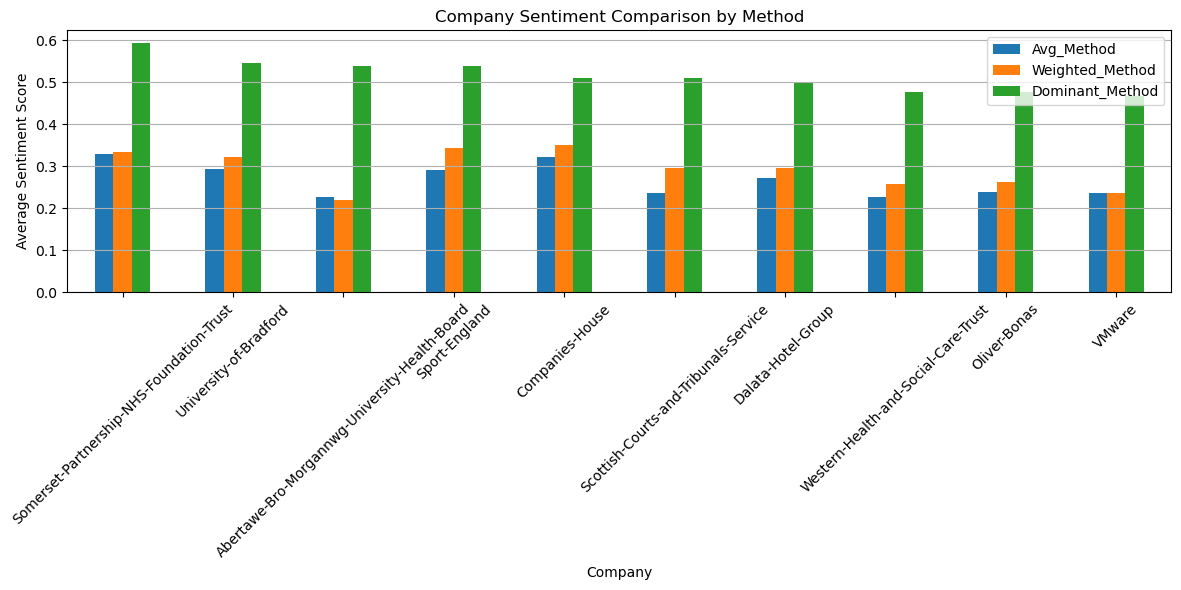

In [18]:
# Visualize the distribution of the overall sentiment scores

# ---- Aggregate the sentiment scores by company ----

# calculate the average sentiment score for each company

avg_sentiment_avg = df.groupby("Company")["Review_Sentiment"].mean().reset_index(name="Avg_Method")
avg_sentiment_weighted = df.groupby("Company")["Review_Sentiment_Weighted"].mean().reset_index(name="Weighted_Method")
avg_sentiment_dominant = df.groupby("Company")["Review_Sentiment_Dominant"].mean().reset_index(name="Dominant_Method")

sentiment_compare = avg_sentiment_avg.merge(avg_sentiment_weighted, on="Company").merge(avg_sentiment_dominant, on="Company")

# ---- Plot the average sentiment scores ----
# For instance, sort companies by the Dominant Method and pick the top 10
top_companies = sentiment_compare.sort_values("Dominant_Method", ascending=False).head(10)

# Set the company as index and plot a bar chart comparing the three methods
top_companies.set_index("Company").plot(kind="bar", figsize=(12, 6))
plt.title("Company Sentiment Comparison by Method")
plt.ylabel("Average Sentiment Score")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.tight_layout()
plt.show()





---

### Model 2: BERT (HuggingFace Transformer Model)